### Fullerton Small Amp Load Line

In this notebook, we'll explore load line placement using the 6K6-GT datasheet
<hr>
<br><b>6K6-GT GE 3-50</b><br>
<img src='../docs/6K6GT-250V-Plate Characteristics.png'>
<hr>
#### References
[The Valve Wizard - The Push-Pull Power Output Stage](http://www.valvewizard.co.uk/pp.html)<br>
#### Data Extraction

In [10]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [11]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import interpolate
import math
import scipy.integrate as integrate
from ipywidgets import interact
import ipywidgets as widgets


# used engauge to extract plot data from datasheet
fn = "../docs/6K6GTPlateCharacteristics.csv"
datasheetCurveData = pd.read_csv(fn)

colnames = datasheetCurveData.columns.values
colcount = len(colnames)
rowcount = len(datasheetCurveData[colnames[0]])

# do a little clean up
# remove negative values of plate current
for i in range(1,colcount):
    for j in range(rowcount):
        if datasheetCurveData[colnames[i]][j] < 0.00:
            datasheetCurveData[colnames[i]][j] = 0.0
            
# engauge adds bogus points on curves where plate voltage is greater than curve
# scan through array data column at a time, find point where engauge starts duplicating data
# calculate slope and y-axis intercept (m, b) then fill data past that point with a line
for i in range(1,colcount):
    m = 0
    b = 0
    for j in range(rowcount):
        if datasheetCurveData[colnames[i]][j] > 0.01:
            try:
                if m == 0:
                    if datasheetCurveData[colnames[i]][j] == datasheetCurveData[colnames[i]][j+40]:
                        # now need to find the average of the past slopes
                        slopeCount = 10
                        sum = 0
                        for k in range(j-slopeCount,j):
                            sum += (datasheetCurveData[colnames[i]][k] - datasheetCurveData[colnames[i]][k-1])/(datasheetCurveData['PlateVoltage'][k] - datasheetCurveData['PlateVoltage'][k-1])
                        m = sum / slopeCount;
                        if m < 0.0:
                            m = 0.0;
                        b = datasheetCurveData[colnames[i]][j] - m*datasheetCurveData['PlateVoltage'][j]
                        # print j,datasheetCurveData[colnames[i]][j],m,b
                if m != 0:
                    datasheetCurveData[colnames[i]][j] = m*datasheetCurveData['PlateVoltage'][j] + b
            except KeyError:
                pass # j+2 is now > rowcount for the higher curves

In [12]:
datasheetCurveData.head(5)

,PlateVoltage,0V,-5V,-10V,-15V,-20V,-25V,-30V,-35V
0,0.3,0.00030,0.00015,0.00030,0.00059,0.0003,0.0003,0.00104,0.00104
1,0.3,0.00030,0.00015,0.00030,0.00059,0.0003,0.0003,0.00104,0.00104
2,0.6,0.00111,0.00114,0.00030,0.00059,0.0003,0.0003,0.00104,0.00104
3,0.6,0.00112,0.00114,0.00030,0.00059,0.0003,0.0003,0.00104,0.00104
4,0.9,0.00194,0.00214,0.00172,0.00165,0.0003,0.0003,0.00104,0.00104


In [13]:
datasheetCurveData.tail(5)

,PlateVoltage,0V,-5V,-10V,-15V,-20V,-25V,-30V,-35V
103,398.73,0.09361,0.07403,0.05609,0.04111,0.02865,0.01827,0.01085,0.00582
104,399.16,0.09361,0.07403,0.05609,0.04111,0.02865,0.01827,0.01085,0.00582
105,399.30,0.09361,0.07403,0.05609,0.04111,0.02865,0.01827,0.01085,0.00582
106,399.57,0.09361,0.07403,0.05609,0.04111,0.02865,0.01827,0.01086,0.00581
107,399.85,0.09361,0.07403,0.05609,0.04111,0.02865,0.01827,0.01086,0.00581


<hr>
#### Load Line Placement

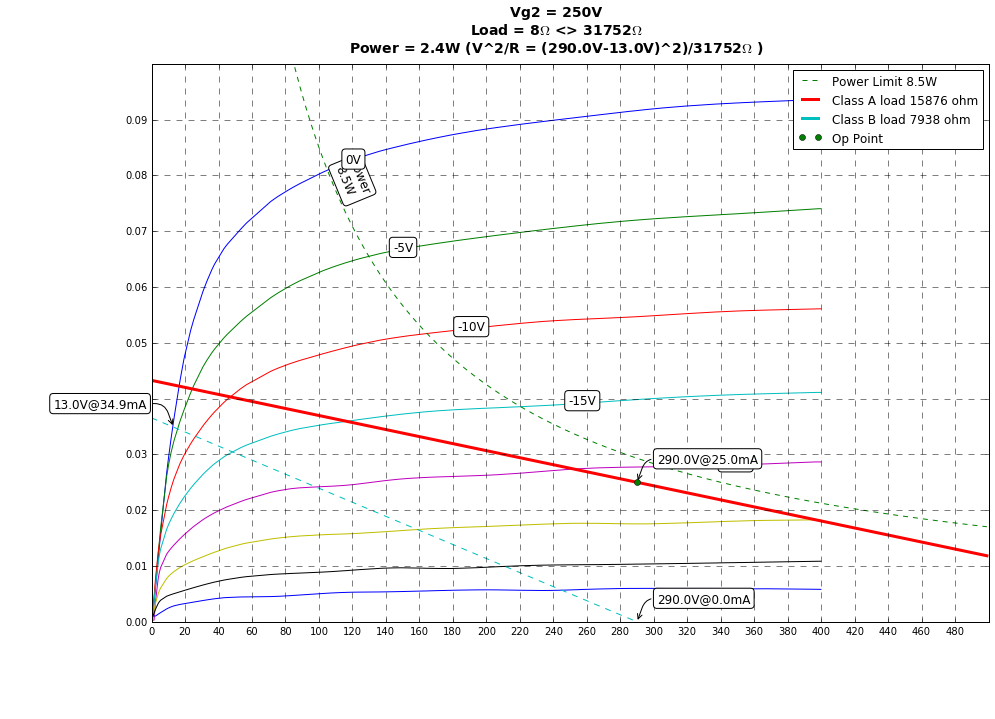

In [14]:
#initial values
Ia = 0.025   # plate current mA
Va = 290.0   # plate voltage V
Rl = 8       # speaker impedance
n  = 63      # pri/sec turns ratio

Pd = 8.5 # watts

VaMAX = 500.0
IaMAX = 0.100
GraphWidth = 840 # get these from jpg size 
GraphHeight = 560

# later, we find intersection of loadline with plate current curves by resampling
# so all have the same x values.
# http://stackoverflow.com/questions/17928452/find-all-intersections-of-xy-data-point-graph-with-numpy
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html

PlateVoltages = np.arange(0,VaMAX,1.0)
saturationCurveVoltage = '0V'
cutoffCurveVoltage = '-32V' # tweak this based on lowest grid voltage curve on graph you have



# creating 1D interpolation functions from the datasheet extracted curves
iaf = {}
for i in range(1,colcount):
    iaf[colnames[i]] = {'valueAt': None,'loadLineIntersectionV':0,'loadLineIntersectionI':0}
    iaf[colnames[i]]['valueAt'] = interpolate.interp1d(datasheetCurveData['PlateVoltage'].tolist(), 
                                            datasheetCurveData[colnames[i]].tolist())

m_A = 0.0
b_A = 0.0
m_B = 0.0
b_B = 0.0
vllintersect = 0.0
illintersect = 0.0
    
def plotAB(_Ia,_Va,_Rl,_n):
    global Ia,Va,Rl,n,m_A,b_A,m_B,b_B,vllintersect,illintersect
    Ia = _Ia # set the slider values to global
    Va = _Va
    Rl = _Rl
    n  = _n

    # plot the csv colums versus plate/anode voltage
    fig = plt.figure(figsize=(15, 10))
    null = [plt.plot(datasheetCurveData['PlateVoltage'],
                     datasheetCurveData[colnames[x]],label='') for x in range(1,colcount)]
    plt.grid(linestyle='--', linewidth=0.5)
    null = plt.xticks(np.arange(0,VaMAX,20))
    null = plt.yticks(np.arange(0,IaMAX,0.01))

    # plot power dissipation limit curve
    null = plt.plot(PlateVoltages, Pd/PlateVoltages,label='Power Limit %0.1fW'%Pd,linestyle=(0, (5.0, 5.0)))

    null = plt.xlim([0,VaMAX])
    null = plt.ylim([0,IaMAX])

    def placeLabel(plt,text,x,y,angle):
        null = plt.annotate(s=text,
                        rotation=angle,
                        xy=(x,y),
                        xycoords='data',
                        xytext=(0,0),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        # arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=70,rad=10")
                           )


    powerLimitVoltage = 108.0 # tweak this to place the label in a good spot along PD
    slope = -Pd/(powerLimitVoltage*powerLimitVoltage)
    graphSlope = slope*(GraphHeight/IaMAX)/(GraphWidth/VaMAX)
    angle = (180.0/np.pi) * np.arctan(graphSlope)
    placeLabel(plt,"Power\n%.1fW"%Pd,powerLimitVoltage,Pd/powerLimitVoltage,angle)

    for i in range(1,colcount):
        l = colnames[i]
        for j in range(rowcount):
            if datasheetCurveData['PlateVoltage'][j]*datasheetCurveData[colnames[i]][j] > (Pd+1.0):
                placeLabel(plt,l,datasheetCurveData['PlateVoltage'][j],datasheetCurveData[colnames[i]][j],0)
                break

    plateToPlateImpedance = float(Rl * n**2)
    plateImpedance_A = plateToPlateImpedance / 2.0 # push-pull plateImpedance is 1/2 of a-a
    #                                       when running in class A
    plateImpedance_B = plateToPlateImpedance / 4.0 # push-pull plateImpedance is 1/4 of a-a
    #                                       when running in class B
  
    m_A = -1/plateImpedance_A
    b_A = Ia + Va/plateImpedance_A
    m_B = -1/plateImpedance_B
    b_B = Va/plateImpedance_B
    
    vllintersect = -(b_A - b_B)/(m_A - m_B)
    illintersect = m_A * vllintersect + b_A
    
    PlateVoltages_lt = np.array(np.where(PlateVoltages <= vllintersect))[0]
    PlateVoltages_gt = np.array(np.where(PlateVoltages >= vllintersect))[0]

    ll_A_lt = m_A*PlateVoltages_lt+b_A    
    ll_A_gt = m_A*PlateVoltages_gt+b_A
    ll_B_lt = m_B*PlateVoltages_lt+b_B
    ll_B_gt = m_B*PlateVoltages_gt+b_B

    # print vllintersect,illintersect
    null = plt.annotate(s="%.1fV@%.1fmA"%(vllintersect,illintersect*1000),
                        xy=(vllintersect,illintersect),
                        xycoords='data',
                        xytext=(20,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=70,rad=10"))

    lastplot = plt.plot(PlateVoltages_lt,ll_A_lt,linestyle='dashed')
    null = plt.plot(PlateVoltages_gt,ll_A_gt,label='Class A load %d ohm'%plateImpedance_A,linewidth=3,color=lastplot[0].get_color())
    #null = plt.plot(Va,Ia, 'or',label='Op Point',color='g')
    
    lastplot = plt.plot(PlateVoltages_gt,ll_B_gt,linestyle='dashed')
    null = plt.plot(PlateVoltages_lt,ll_B_lt,label='Class B load %d ohm'%plateImpedance_B,linewidth=3,color=lastplot[0].get_color())


    for i in range(1,colcount):
        mindiff = 10
        for v in PlateVoltages:
            try:
                ia = iaf[colnames[i]]['valueAt'](v)
                iall = m_B*v+b_B
                diff = abs(ia - iall)

                if diff < mindiff:
                    vinter = v
                    iinter = iall
                    mindiff = diff
            except ValueError:
                pass

        iaf[colnames[i]]['loadLineIntersectionV'] = vinter
        iaf[colnames[i]]['loadLineIntersectionI'] = iinter

        if colnames[i] == cutoffCurveVoltage:
            break

    vsat = iaf[colnames[1]]['loadLineIntersectionV']
    isat = iaf[colnames[1]]['loadLineIntersectionI']
     
    null = plt.annotate(s="%.1fV@%.1fmA"%(vsat,isat*1000),
                        xy=(vsat,isat),
                        xycoords='data',
                        xytext=(-120,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=110,rad=10"))    

    null = plt.annotate(s="%.1fV@%.1fmA"%(Va,Ia*1000),
                        xy=(Va,Ia),
                        xycoords='data',
                        xytext=(20,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=70,rad=10"))

    null = plt.plot(Va,Ia, 'or',label='Op Point',color='g')

    vcut = Va
    icut = 0.0
    null = plt.annotate(s="%.1fV@%.1fmA"%(vcut,icut*1000),
                        xy=(vcut,icut),
                        xycoords='data',
                        xytext=(20,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=70,rad=10"))



    power = (Va - vsat)**2/plateToPlateImpedance
    title = "Vg2 = 250V\nLoad = %d$\Omega$ <> %d$\Omega$\nPower = %.1fW (V^2/R = (%.1fV-%.1fV)^2)/%d$\Omega$ )"%(Rl,plateToPlateImpedance,power,Va,vsat,plateToPlateImpedance)
    null = plt.suptitle(title,fontsize=14, fontweight='bold')
    null = plt.legend()
 
# plotAB(Ia,Va,Rl,n)
    
null = interact(plotAB,
             _Ia=widgets.FloatSlider(min=0.01,max=0.1,step=0.0025,value=Ia),
             _Va=widgets.FloatSlider(min=50,max=500,step=5,value=Va),
             _Rl=widgets.FloatSlider(min=2,max=16,step=2,value=Rl),
             _n=widgets.FloatSlider(min=10,max=75,step=1,value=n)
                )

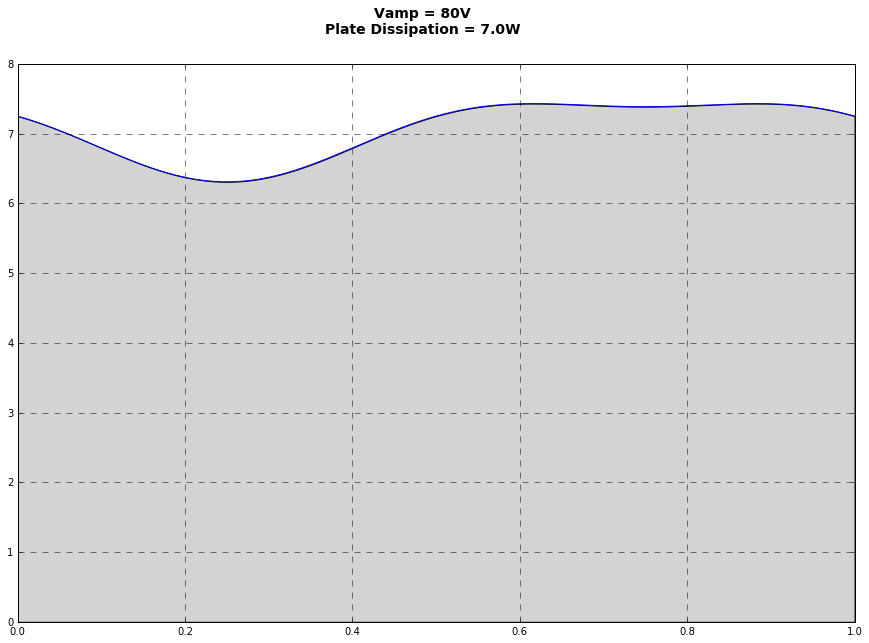

In [15]:
def get_pd(t,v_amplitude):
    global Ia,Va,Rl,n,m_A,b_A,m_B,b_B,vllintersect,illintersect
    t = t * 2 * np.pi
    v = Va - v_amplitude*np.sin(t)
    if v <= vllintersect:
        i = m_B * v + b_B
    else:
        i = m_A * v + b_A
    if i < 0:
        i = 0
    return v*i

def plotInstanteousPowerPositive(v_amplitude):
    plt.figure(figsize=(15, 10))
    plt.grid(linestyle='--', linewidth=0.5)

    t = np.linspace(0,1,1000)
    get_pd_vect = np.vectorize(get_pd,otypes=[float])
    pd = get_pd_vect(t,v_amplitude)

    plt.plot(t,pd)
    plt.fill_between(t,0,pd,facecolor='lightgrey')
    
    pdtotal = integrate.quad(get_pd, 0, 1,args=(v_amplitude,))
    
    title = "Vamp = %dV\nPlate Dissipation = %.1fW"%(v_amplitude,pdtotal[0])
    null = plt.suptitle(title,fontsize=14, fontweight='bold')
    plt.show()
    
#null = interact(plotInstanteousPowerPositive,
#             v_amplitude=widgets.FloatSlider(min=0,max=360,step=5,value=100))
plotInstanteousPowerPositive(80)

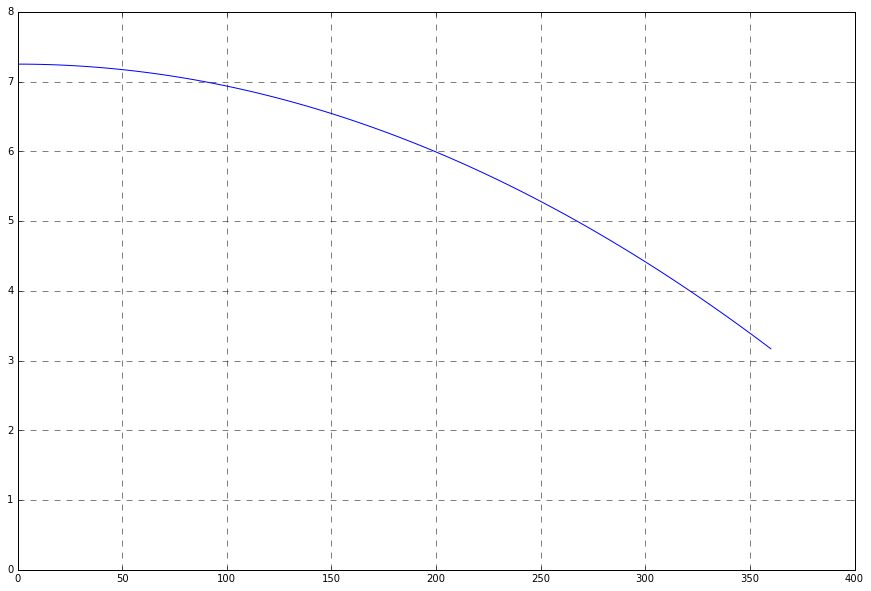

In [16]:
voltages = np.linspace(0,360,90)
platedissipations = []
for v in voltages:
    platedissipations.append(integrate.quad(get_pd, 0, 1,args=(v,)))
platedissipations = np.array(platedissipations)

plt.figure(figsize=(15, 10))
plt.grid(linestyle='--', linewidth=0.5)
plt.plot(voltages,platedissipations)
plt.show()